In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
from multiprocessing import Pool

%matplotlib inline

In [166]:
allele = 'HLA-B35_03'
files = glob.glob('/dfs/user/yhr/neopeptide/results/'+allele+'/*')

In [2]:
# Read an parse all peptide lines from text

def get_peptides(f):
    with open(f, "r+") as read:
            text=read.readlines()

    peptide_text = []
    for it, line in enumerate(text):
        if line[1:4]=='Pos':
            k = 2
            while text[it+k][0] != '-':
                peptide_text.append(text[it+k])
                k = k+1
    return peptide_text

def get_BA(peptide_out):
    ba = [x for x in peptide_out.split(' ')if len(x)>0][15]
    id_ = [x for x in peptide_out.split(' ')if len(x)>0][10]
    return (id_, float(ba))

def get_all_BA(peptide_outs):
    return [get_BA(p) for p in peptide_outs]

In [169]:
# Get all peptide results for a given allele
peptide_outs_all = []
for f in files:
    if f[-2:] != 'sh' or f[-2:] != 'ip':
        try:
            peptide_outs_all.append(get_peptides(f))
        except:
            continue

In [3]:
def Map(F, x, workers):
    """
    wrapper for imap()
    Spawn workers for parallel processing
    
    """
    with Pool(workers) as pool:
        #ret = pool.map(F, x)
        ret = list(tqdm.tqdm(pool.imap(F, x), total=len(x)))
    return ret

In [ ]:
# Read in binding affinity for all output files
BAs = Map(get_all_BA, peptide_outs_all, workers=50)
BAs_flat = [item for sublist in BAs for item in sublist]

100%|██████████| 68/68 [06:29<00:00,  5.73s/it]  


In [ ]:
# Save output to file
with open('BAs_flat_'+allele+'.txt', 'w') as f:
    for it, item in enumerate(BAs_flat):
        if it%1000000 == 0:
            print(it)
        f.write("%s\n" % str(item))

In [ ]:
plot_df = pd.DataFrame(BAs_flat)

In [ ]:
plot_df.to_pickle('BAs_flat_'+allele+'.pkl')

### Read in processed data

In [4]:
# Read in file
with open('BAs_flat_'+allele+'.txt', 'r') as f:
    content = f.readlines()
    
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 

In [18]:
data_mat = []
for c in content:
    data_mat.append([ci.strip('()') for ci in c.split(',')])

In [19]:
# Create a dataframe
plot_df = pd.DataFrame(data_mat)
plot_df[0] = plot_df[0].astype('float')

In [23]:
# Save dataframe as pickle
plot_df.to_pickle('BAs_flat_'+allele+'.pkl')

### Transcript data

In [5]:
import pickle

ID_dict = np.load('/lfs/rambo/0/yhr/neopeptide/tim_data/ID_dict.npy', allow_pickle=True)
ID_dict = ID_dict.item()

# Link gene names to tpm
# RNA seq data
RNAseq = pd.read_csv('./fpkm_tpm.csv')

# tpm values
tpm_dict = RNAseq.set_index('geneID').to_dict()['TA1_wt1']

In [7]:
len(ID_dict.keys())

2301322

In [176]:
import matplotlib
from pylab import figure, cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

font = {'size'   : 16}
matplotlib.rc('font', **font)

def xid_to_geneid(k):
    k = ':'.join(k.split('_'))
    v = ID_dict[k]
    return v.split('|')[0].split(':')[1]

def xid_to_tpm(v):
    try:
        geneid = xid_to_geneid(v)
        return tpm_dict[geneid]
    except:
        return 0
    
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'$10^{{{}}}$'.format(b)

def get_num(a,b):
    return a-b+a

def get_heatmap(plot_df):
    yedges = [0, 2, 20, 80, 120, 380, 620, 1380, 2000, 4000, 6000, 10000]
    xedges = [2, 18, 80, 120, 380, 620, 1000, 10000, 20000, 30000, 40000, 50000]
    H, xedges, yedges = np.histogram2d(plot_df[1].values, plot_df['tpm'].values, bins=(xedges, yedges))      

    f = figure(figsize=(10,10))

    xticks = np.convolve(xedges, np.ones(2)/2, mode='valid').astype('int')
    yticks = np.convolve(yedges, np.ones(2)/2, mode='valid').astype('int')
    ax = f.add_axes([0.17, 0.02, 0.72, 0.79])
    axcolor = f.add_axes([0.90, 0.02, 0.03, 0.79])
    #ax=plt.gca()

    ax.set_xlabel('RNA (tpm)')
    ax.set_xticks(range(len(yticks)))
    ax.set_yticks(range(len(xticks)))
    ax.set_yticklabels(xticks)
    ax.set_xticklabels(yticks)
    ax.set_ylabel('Binding affinity (nM)')

    im = ax.matshow(H, norm=LogNorm(vmin=1e2, vmax=1e8), cmap='inferno')
    #f.colorbar(im, cax=axcolor,  format='$%.0e$')
    f.colorbar(im, cax=axcolor,  format=ticker.FuncFormatter(fmt))

    ax.set_title(allele)
    f.show()
    
    return H

In [201]:
# Set up plotting df

plot_df = plot_df.rename(columns = {0:'ID'})
plot_df['tpm'] = plot_df['ID'].apply(xid_to_tpm)
plot_df = plot_df.fillna(0)

In [233]:
yedges = [0, 50, 100, 250, 500, 1000, 5000]
xedges = [1, 10, 100, 1000, 10000, 100000]

yedges = [0, 2, 20, 80, 120, 380, 620, 1380, 2000, 4000, 6000, 10000]
xedges = [2, 18, 80, 120, 380, 620, 1000, 10000, 20000, 30000, 40000, 50000]
H, xedges, yedges = np.histogram2d(plot_df[1].values, plot_df['tpm'].values, bins=(xedges, yedges))

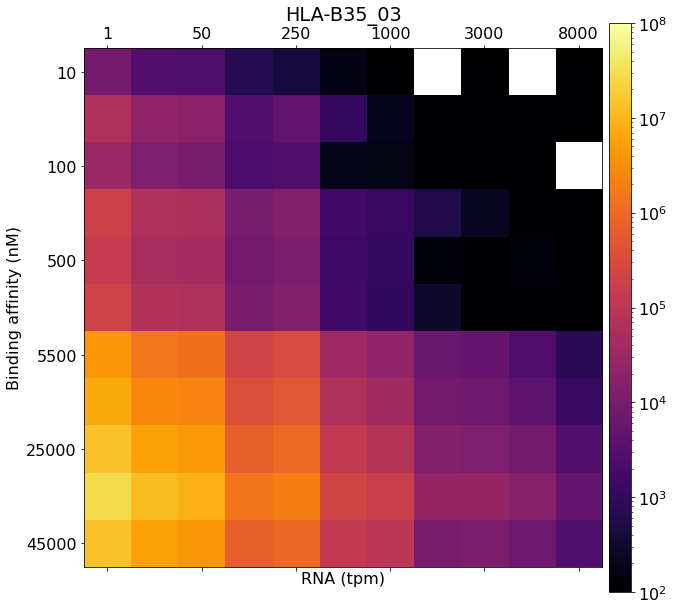

In [238]:
H = get_heatmap(plot_df)

In [248]:
np.save('H_'+allele, H)

### Make heatmap

Text(0.5, 1.0, 'Allele:HLA-A03_01')

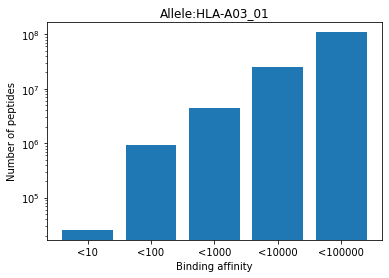

In [58]:
plt.bar(['<'+str(i) for i in heatmap[1][1:]], heatmap[0])
plt.xlabel('Binding affinity')
plt.ylabel('Number of peptides')
plt.yscale('log')
plt.title('Allele:'+allele)

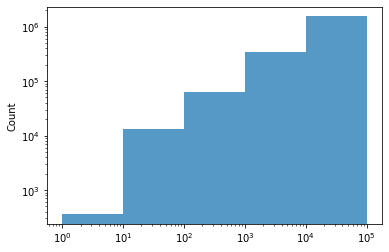

In [15]:
# Plot distirubtion of binding affinities
_ = sns.histplot(BAs, bins = [10**i for i in range(6)])
plt.xscale('log')
plt.yscale('log')